In [19]:
import pandas as pd

rw = pd.read_csv('/content/drive/MyDrive/python project/wine+quality/winequality-red.csv', sep=';')
ww = pd.read_csv('/content/drive/MyDrive/python project/wine+quality/winequality-white.csv', sep=';')

rw['type'] = 'red'
ww['type'] = 'white'

wdata = pd.concat([rw, ww])

In [20]:
print(wdata.isnull().sum())
wdata.dropna(inplace=True)
print(f"Duplicates: {wdata.duplicated().sum()}")
wdata.drop_duplicates(inplace=True)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64
Duplicates: 1177


In [21]:
wdata['quality_class'] = wdata['quality'].apply(lambda x: 'Good' if x >= 7 else 'Bad')
print(wdata['quality_class'].value_counts())

quality_class
Bad     4311
Good    1009
Name: count, dtype: int64


In [22]:
def remoutl(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
wclean = remoutl(wdata, 'residual sugar')
print(f"Removed {len(wdata) - len(wclean)} outliers")
wclean.to_csv('cleanedwinedata.csv', index=False)

Removed 141 outliers


Exploratory Data Analysis

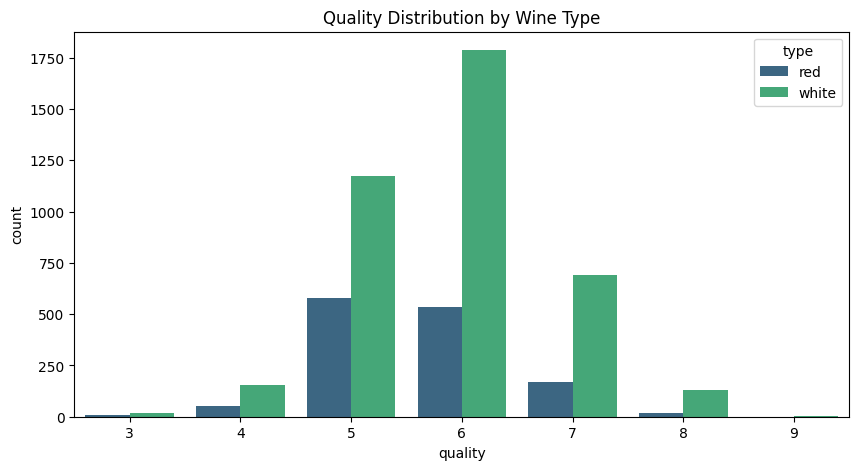

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(data=wdata, x='quality', hue='type', palette='viridis')
plt.title('Quality Distribution by Wine Type')
plt.show()

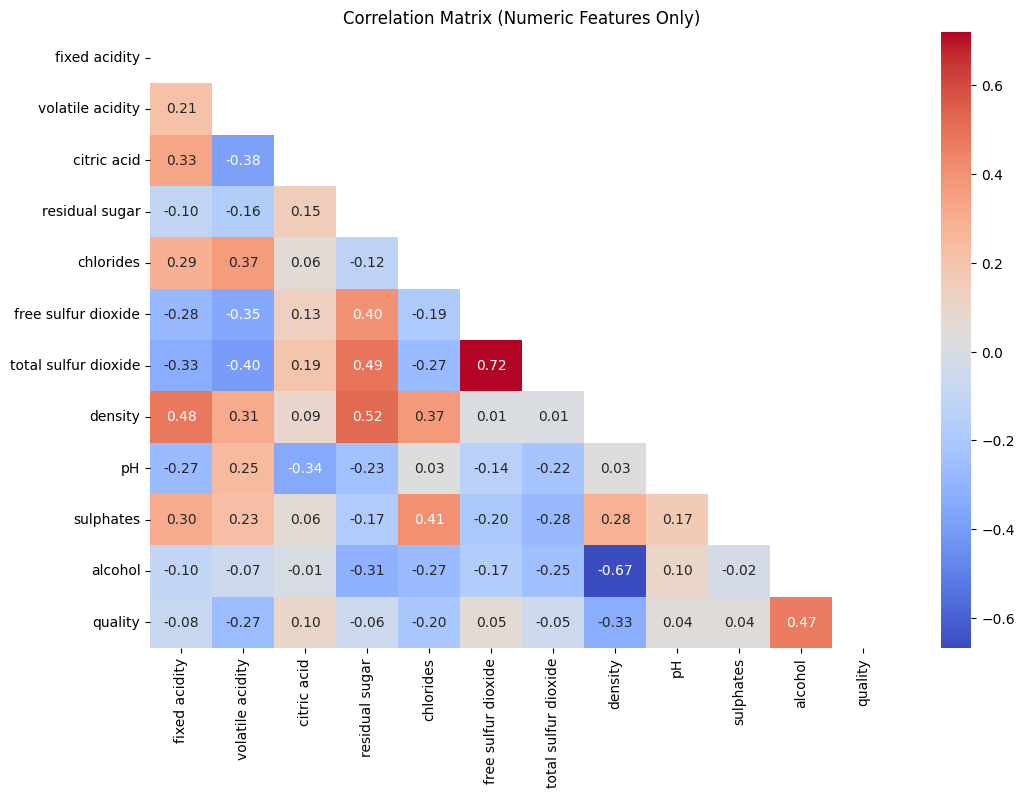

In [24]:
import numpy as np
numeric_data = wdata.select_dtypes(include=['float64', 'int64'])
corr = numeric_data.corr()
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

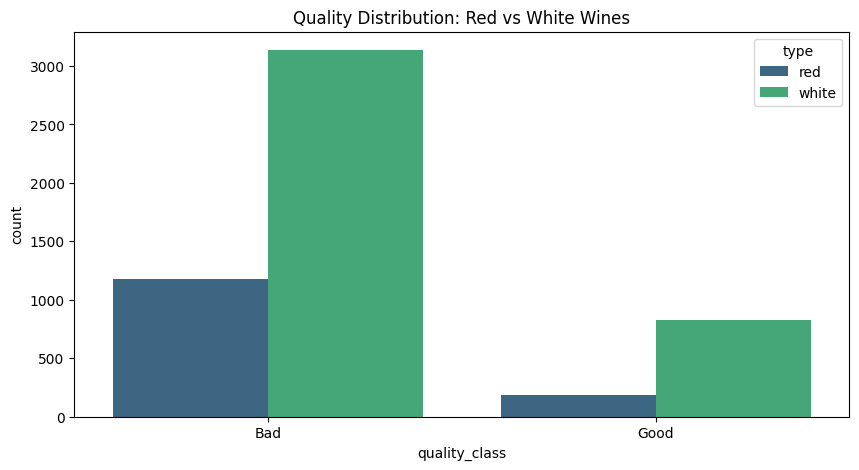

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(data=wdata, x='quality_class', hue='type', palette='viridis')
plt.title('Quality Distribution: Red vs White Wines')
plt.show()

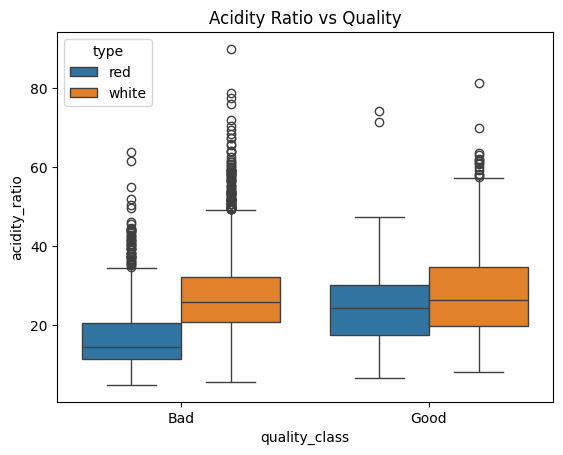

In [26]:
wdata['acidity_ratio'] = wdata['fixed acidity'] / wdata['volatile acidity']
sns.boxplot(data=wdata, x='quality_class', y='acidity_ratio', hue='type')
plt.title('Acidity Ratio vs Quality')
plt.show()

In [27]:
from scipy.stats import chi2_contingency
print("\nQuality by Wine Type:")
print(pd.crosstab(wdata['type'], wdata['quality_class']))
chi2, p, _, _ = chi2_contingency(pd.crosstab(wdata['type'], wdata['quality_class']))
print(f"\nChi-squared test p-value: {p:.4f} (significant if < 0.05)")


Quality by Wine Type:
quality_class   Bad  Good
type                     
red            1175   184
white          3136   825

Chi-squared test p-value: 0.0000 (significant if < 0.05)


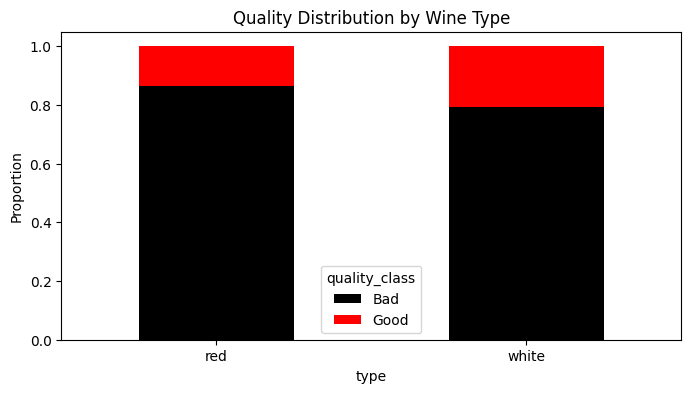

In [28]:
import matplotlib.pyplot as plt
cross_tab = pd.crosstab(wdata['type'], wdata['quality_class'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, color=['black','red'], figsize=(8, 4))
plt.title('Quality Distribution by Wine Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

In [29]:
wdata['type_encoded'] = wdata['type'].map({'red': 0, 'white': 1})

In [31]:
X = wdata.drop(['quality', 'quality_class', 'type'], axis=1)  # Features
y = wdata['quality_class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

import joblib
joblib.dump(model, 'model.joblib')  # Saves model
joblib.dump(list(X.columns), 'features.joblib')  # Saves feature names

              precision    recall  f1-score   support

         Bad       0.86      0.97      0.91       848
        Good       0.73      0.36      0.48       216

    accuracy                           0.84      1064
   macro avg       0.79      0.66      0.69      1064
weighted avg       0.83      0.84      0.82      1064



['features.joblib']

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# Load model and features
try:
    model = joblib.load('model.joblib')
    feature_names = joblib.load('features.joblib')
except FileNotFoundError:
    st.error("Model files not found! Please add:")
    st.code("""
    - model.joblib
    - features.joblib
    """)
    st.stop()

st.title(" Wine Quality Class Predictor")

# Create input form with REAL data ranges (example for wine)
FEATURE_RANGES = {
    'fixed acidity': (4.6, 15.9),
    'volatile acidity': (0.08, 1.58),
    'citric acid': (0.0, 1.66),
    'residual sugar': (0.9, 65.8),
    'chlorides': (0.01, 0.34),
    'free sulfur dioxide': (1.0, 289.0),
    'total sulfur dioxide': (6.0, 440.0),
    'density': (0.99, 1.04),
    'pH': (2.72, 3.82),
    'sulphates': (0.22, 1.08),
    'alcohol': (8.0, 14.9)
}

inputs = {}
for feature in feature_names:
    min_val, max_val = FEATURE_RANGES.get(feature, (0.0, 15.0))  # Default fallback
    inputs[feature] = st.slider(
        label=feature.replace('_', ' ').title(),
        min_value=float(min_val),
        max_value=float(max_val),
        value=float((min_val + max_val)/2)  # Midpoint
    )

if st.button("Predict Quality Class"):
    input_df = pd.DataFrame([inputs])[feature_names]  # Maintain feature order

    try:
        prediction = model.predict(input_df)[0]
        proba = model.predict_proba(input_df)[0]

        st.success(f"Predicted Class: **{prediction}**")

        st.subheader("Probability Breakdown")
        for class_name, prob in zip(model.classes_, proba):
            st.progress(float(prob), text=f"{class_name}: {prob:.1%}")

    except Exception as e:
        st.error(f"Prediction failed: {str(e)}")

In [ ]:
!pip install pyngrok
from pyngrok import ngrok
NGROK_AUTH_TOKEN = "2viN1oAchbwljUbrFDcfHr4zG6w_4p5MaxNgENPr2WzySXJa8"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [ ]:
from pyngrok import ngrok

!pkill -f ngrok || true
!pkill -f streamlit || true

!streamlit run app.py --server.port 8501 &>/dev/null &

try:
    public_url = ngrok.connect(8501, bind_tls=True).public_url
    print("✨ Your Streamlit app is live at:", public_url)
except Exception as e:
    public_url = ngrok.connect(addr='8501', proto='http').public_url
    print("✨ Your Streamlit app is live at:", public_url)